# Injection-Recovery

This notebook shows how the injection-recovery process works.

In [17]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from numpy.random import uniform, choice

from muldoon.met_timeseries import MetTimeseries
from muldoon.read_data import read_Perseverance_MEDA_data
from muldoon.utils import modified_lorentzian

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


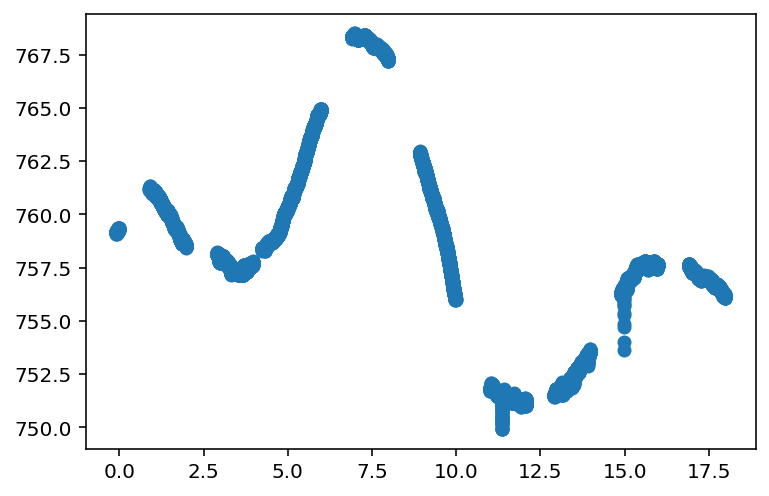

In [18]:
# Read in data file
filename = "WE__0089___________DER_PS__________________P01.CSV"
ind = filename.find("WE__")

time, pressure = read_Perseverance_MEDA_data(filename)
mt = MetTimeseries(time, pressure)

plt.scatter(mt.time, mt.pressure)

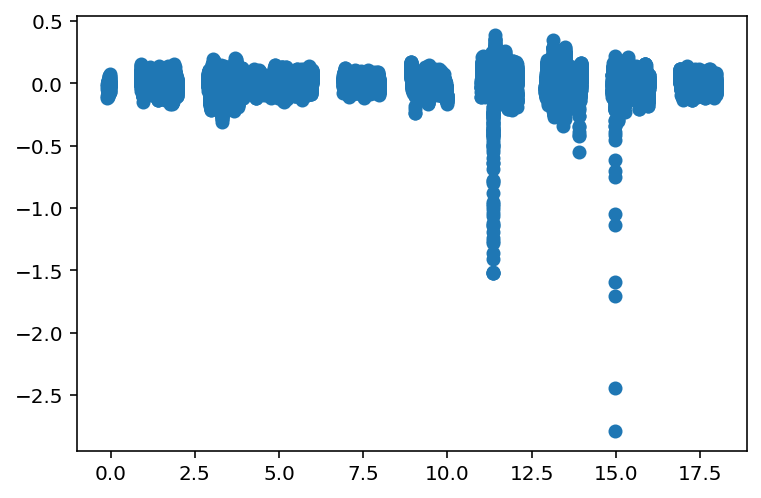

In [19]:
# Next, the injection-recovery process detrends the data
window_width = 500./3600. # 500 second-window
mt.detrend_pressure_timeseries(window_width)

plt.scatter(mt.time, mt.detrended_pressure)

In [20]:
mt.apply_lorentzian_matched_filter();
mt.find_vortices(detection_threshold=detection_threshold);

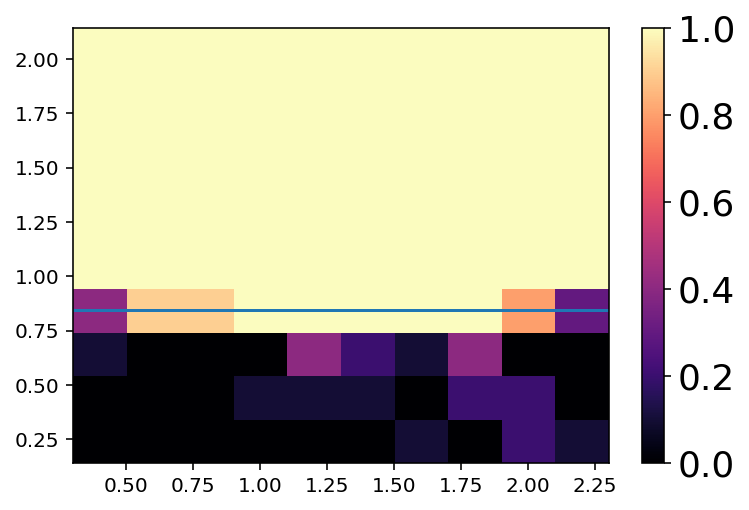

In [21]:
# Next set up a grid of vortex pressure signals
# Grids are log-spaced because values usually span wide range.
mn_deltaP = 0.1
mx_deltaP = 10.
num_deltaPs = 10
deltaP_grid = 10.**(np.linspace(np.log10(mn_deltaP), np.log10(mx_deltaP), num_deltaPs))

mn_Gamma = 2.0
mx_Gamma = 200.
num_Gammas = 10
Gamma_grid = 10.**(np.linspace(np.log10(mn_Gamma), np.log10(mx_Gamma), num_Gammas))/3600. # convert to hours

# Number of trials with each combination of deltaP and Gamma
num_trials = 10

matched_filter_fwhm = 2.*mt.sampling
matched_filter_depth = 1./np.pi 
num_fwhms = 3.

detection_threshold = 7.

# Whether or not a detection was made
detection_successful = np.zeros([num_deltaPs, num_Gammas, num_trials])
for i in range(num_deltaPs):
    for j in range(num_Gammas):
        for k in range(num_trials):
            
            # Generate vortex at random time
            correct_t0 = choice(mt.time)
            vortex_signal = modified_lorentzian(mt.time, 0., 0., correct_t0, deltaP_grid[i], Gamma_grid[j])
            
            # Inject into flipped detrended time-series    
            synthetic_time_series = mt.detrended_pressure + vortex_signal + mt.pressure_trend

            # Make new object
            new_mt = MetTimeseries(mt.time, synthetic_time_series)
            
            new_mt.detrend_pressure_timeseries(window_width)
            
            new_mt.apply_lorentzian_matched_filter(matched_filter_fwhm, matched_filter_depth, num_fwhms=num_fwhms)
            new_mt.find_vortices(detection_threshold=detection_threshold)
            
            # If find_vortices found the vortex
            if(np.any(np.abs(new_mt.time[new_mt.peak_indices] - correct_t0) < Gamma_grid[j])):
                detection_successful[i,j,k] = 1.
z = np.mean(detection_successful, axis=2)
plt.imshow(z, aspect='auto', origin='lower', cmap='magma', 
           extent=[np.log10(mn_Gamma), np.log10(mx_Gamma), 
                   np.log10(mn_deltaP/mt.detrended_pressure_scatter), 
                   np.log10(mx_deltaP/mt.detrended_pressure_scatter)])
plt.axhline(np.log10(7.))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18) 

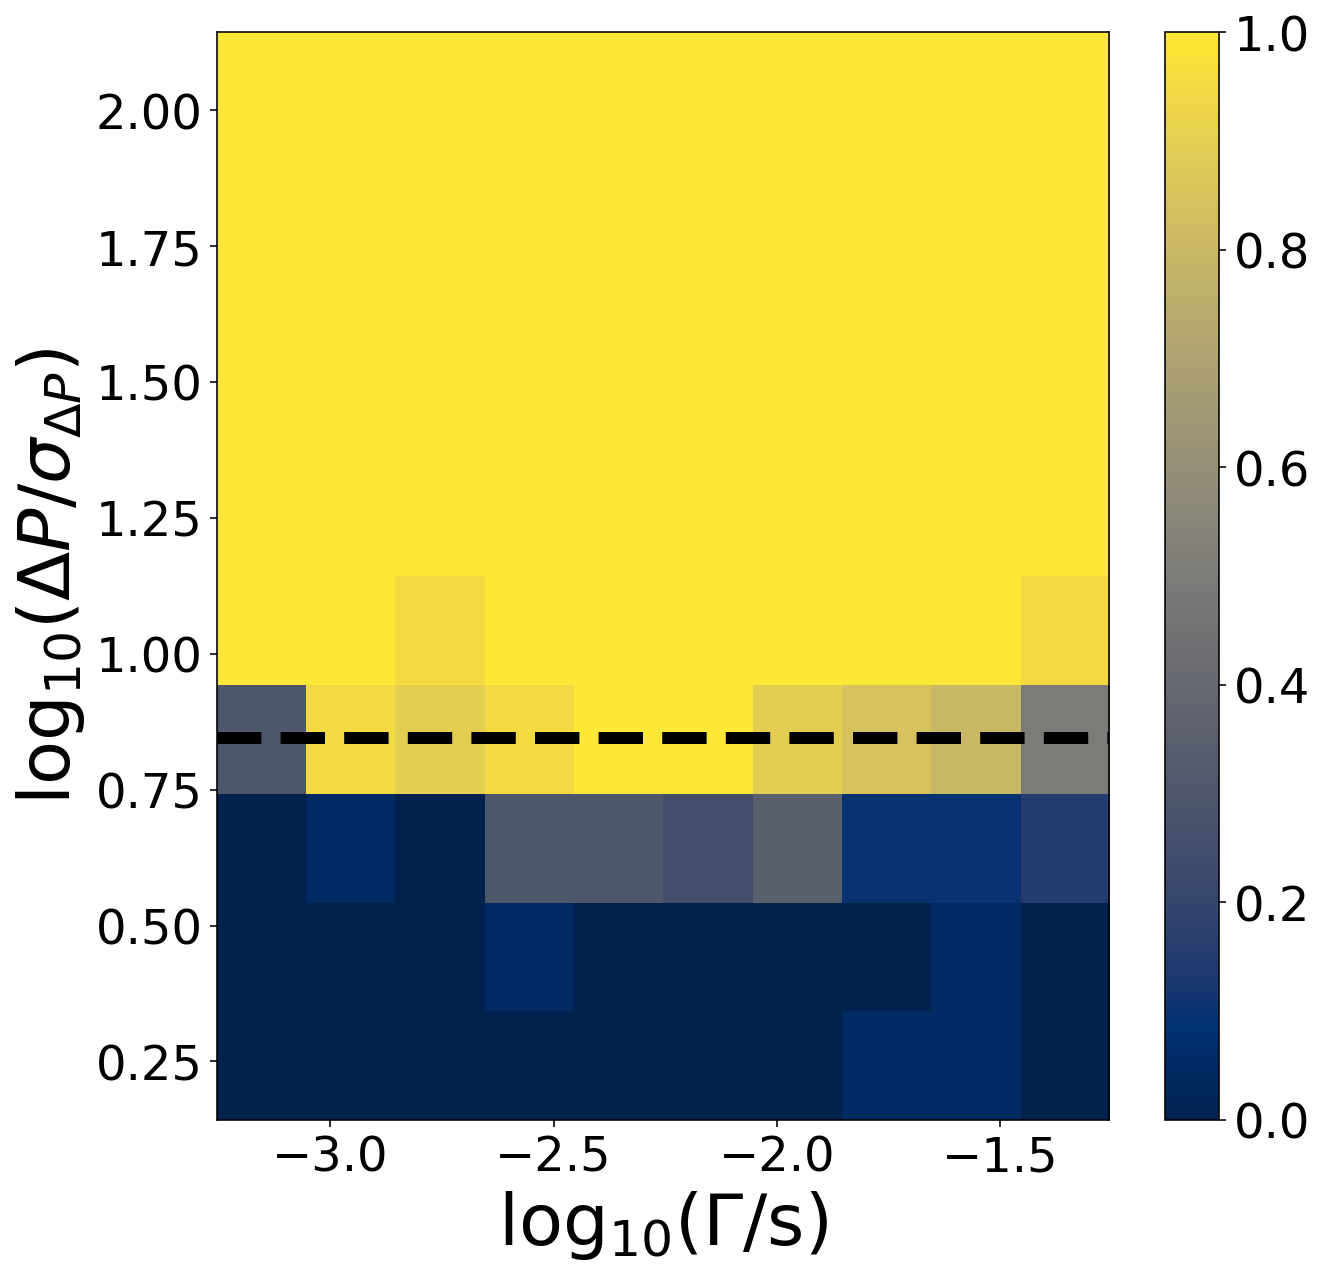

In [43]:
# Or just run the object method - It can take awhile so add trials with care!
# deltaP_grid, Gamma_grid, detection_stats = mt.pressure_timeseries_injection_recovery(num_trials=20)
fig = plt.figure(figsize=(10, 10))

plt.imshow(detection_stats, aspect='auto', origin='lower', cmap='cividis', 
           extent=[np.log10(np.min(Gamma_grid)), np.log10(np.max(Gamma_grid)), 
                   np.log10(np.min(deltaP_grid)/mt.detrended_pressure_scatter), 
                   np.log10(np.max(deltaP_grid)/mt.detrended_pressure_scatter)])

plt.axhline(np.log10(mt.detection_threshold), lw=6, ls='--', color="k")
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=24) 

plt.xlabel(r'$\log_{10} \left( \Gamma/{\rm s} \right)$', fontsize=36)
plt.ylabel(r'$\log_{10} \left( \Delta P/\sigma_{\Delta P} \right)$', fontsize=36)
plt.tick_params(labelsize=24)